In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

In [35]:
DATA_FOLDER = Path("../input/fruits/fruits-360_dataset/fruits-360")
TRAIN = DATA_FOLDER / 'Training'

In [36]:
for i,fruit_class in enumerate(TRAIN.iterdir()):
    print(fruit_class.stem)
    if i > 5: break

Quince
Grapefruit White
Granadilla
Orange
Apple Red 3
Grape White 2
Corn Husk


In [37]:
from tqdm import tqdm
from PIL import Image
import random

def load_data(path, sample=30, shuffle=True):
    res = []
    for fruit_class in tqdm(path.iterdir()):
        for i,image in enumerate(fruit_class.iterdir()):
            res.append((np.array(Image.open(image)),
                        fruit_class.stem,
                        image.stem))
            if i > sample:
                break
    if shuffle:
        random.shuffle(res)
            
    return res

train = load_data(TRAIN)

131it [00:05, 25.77it/s]


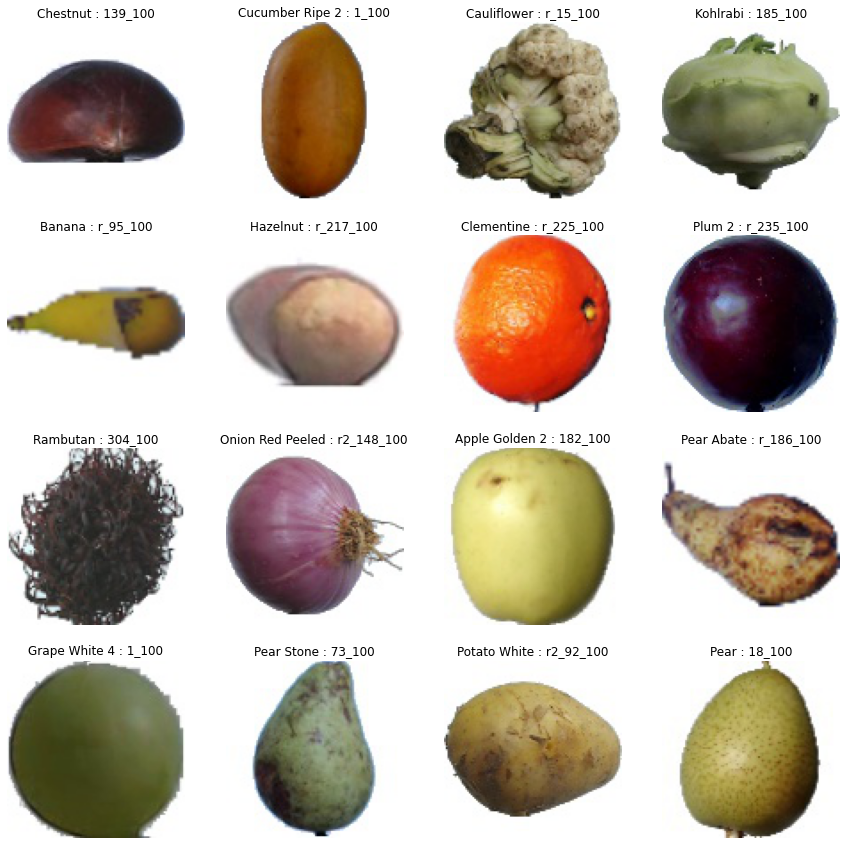

In [38]:
fig,axes = plt.subplots(4,4,figsize=(15,15))
imgs,labels,fnames = zip(*train)

for img,label,fname,ax in zip(imgs,labels,fnames,axes.ravel()):
    plt.sca(ax)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label + " : " + fname )
plt.show()

In [39]:
import copy
labels_copy = list(set(copy.copy(labels)))
random.shuffle(labels_copy)
selected_labels = labels_copy[:20]

In [40]:
selected_labels

['Orange',
 'Cactus fruit',
 'Mango',
 'Ginger Root',
 'Tomato 4',
 'Pineapple',
 'Plum 2',
 'Limes',
 'Mangostan',
 'Papaya',
 'Redcurrant',
 'Pear Williams',
 'Grape White 2',
 'Walnut',
 'Pomelo Sweetie',
 'Onion White',
 'Avocado ripe',
 'Carambula',
 'Fig',
 'Apple Red Delicious']

In [41]:
from collections import defaultdict
acc = defaultdict(list)
for image, label in zip(imgs,labels):
    if label in selected_labels:
        acc[label].append(image.mean((0,1),where=image!=255))

acc = {k:np.array(v) for k,v in acc.items()}

In [42]:
acc.keys()

dict_keys(['Plum 2', 'Onion White', 'Tomato 4', 'Walnut', 'Cactus fruit', 'Pear Williams', 'Redcurrant', 'Avocado ripe', 'Ginger Root', 'Limes', 'Papaya', 'Grape White 2', 'Pomelo Sweetie', 'Carambula', 'Mangostan', 'Orange', 'Pineapple', 'Apple Red Delicious', 'Fig', 'Mango'])

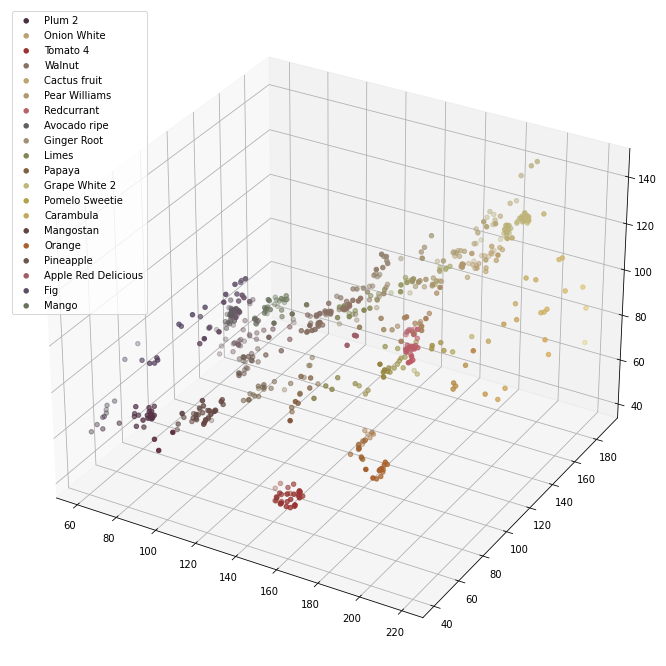

In [43]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for name, rgb_vals in acc.items():
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    ax.scatter(
        r,g,b,
        c = c,
        label=name
    )
plt.legend()
plt.show()

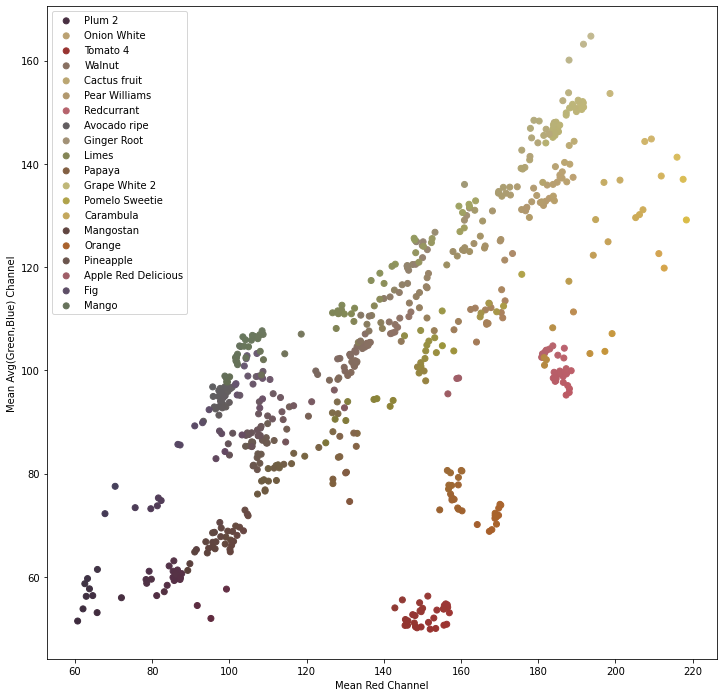

In [44]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

for name, rgb_vals in acc.items():
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    
    ax.scatter(
        r,(g+b)/2,
        c = c,
        label=name
    )
    plt.xlabel('Mean Red Channel')
    plt.ylabel('Mean Avg(Green,Blue) Channel')
plt.legend()
plt.show()

In [72]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

NUM_CLASSES = len(set(labels))

bl_model = tf.keras.Sequential([
    layers.Conv2D(16,4,),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_CLASSES)
])
bl_model(tf.zeros_like(img,tf.float32)[None,...])
bl_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (1, 97, 97, 16)           784       
_________________________________________________________________
re_lu_4 (ReLU)               (1, 97, 97, 16)           0         
_________________________________________________________________
global_average_pooling2d_4 ( (1, 16)                   0         
_________________________________________________________________
dense_4 (Dense)              (1, 131)                  2227      
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [83]:
bl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [84]:
from sklearn.preprocessing import OneHotEncoder

def get_trainable_arrays(train):
    images, labels, _ = zip(*train)
    all_labels = list(set(labels))
    labels_one_hot = [all_labels.index(l) for l in labels]
    labels_one_hot = tf.one_hot(labels_one_hot, NUM_CLASSES)
    images = np.array(images) / 255.
    return images, labels_one_hot

x_train, y_train = get_trainable_arrays(train)

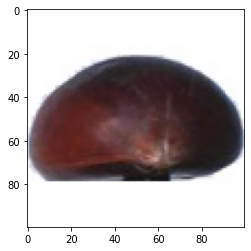

In [82]:
plt.imshow(x_train[0])

In [86]:
bl_model.fit(x_train, y_train, 
             epochs=10, 
             validation_split=.3)

Epoch 1/10
92/92 [==============================] - 3s 31ms/step - loss: 8.0440 - acc: 0.0072 - val_loss: 7.9053 - val_acc: 0.0087
Epoch 2/10
92/92 [==============================] - 2s 25ms/step - loss: 8.1318 - acc: 0.0072 - val_loss: 7.7387 - val_acc: 0.0087
Epoch 3/10
92/92 [==============================] - 2s 25ms/step - loss: 8.0655 - acc: 0.0072 - val_loss: 7.7777 - val_acc: 0.0087
Epoch 4/10
92/92 [==============================] - 2s 25ms/step - loss: 8.0838 - acc: 0.0072 - val_loss: 8.1231 - val_acc: 0.0087
Epoch 5/10
92/92 [==============================] - 2s 25ms/step - loss: 8.2240 - acc: 0.0072 - val_loss: 8.2640 - val_acc: 0.0087
Epoch 6/10
92/92 [==============================] - 2s 25ms/step - loss: 7.8780 - acc: 0.0072 - val_loss: 7.9437 - val_acc: 0.0087
Epoch 7/10
92/92 [==============================] - 2s 25ms/step - loss: 7.6855 - acc: 0.0072 - val_loss: 7.9565 - val_acc: 0.0087
Epoch 8/10
92/92 [==============================] - 3s 32ms/step - loss: 7.6855 - a